# Random Forest Classifier

In [3]:
#import libraries
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [4]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.decomposition import PCA

In [5]:
#Defining the columns that will be used
columns = ['latitude','longitude','Density',
            'mean_temp','height','log_density',
            'Biomass','diameter','mean_prcp',
            'mean_dwp','volume','log_mass',
            'log_volume']

In [6]:
#importing more libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

In [7]:
#Loading the data
more_trees = pd.read_csv('county_tree_temp_dwp_prcp_KT_NS10.csv')

In [8]:
more_trees = more_trees.sort_values(['state_code','county_code','species','year'])
more_trees = more_trees.reset_index(drop = True)

In [9]:
more_trees.head()

,year,state_code,county_code,species,latitude,longitude,volume,Biomass,height,diameter,number_trees,mean_temp,mean_dwp,mean_prcp
0,2001,1,1,American beech,32.638680,-86.697701,0.000000,3.537096,23.0,1.8,1,68.050000,54.900915,0.158415
1,2002,1,1,American beech,32.474319,-86.785027,11.680000,315.524063,108.0,15.1,2,64.719048,56.036415,0.106695
2,2005,1,1,American beech,32.472313,-86.848312,18.958753,470.077309,131.0,19.7,3,64.913151,53.533973,0.146822
3,2007,1,1,American beech,32.600650,-86.652128,66.214596,1628.982895,278.0,46.7,5,66.600015,53.480981,0.103108
4,2008,1,1,American beech,32.472313,-86.848312,20.248340,525.440371,140.0,20.5,3,65.081967,52.525137,0.145301


In [10]:
#defining the top 10 trees
top10 = ['loblolly pine','sweetgum','red maple','slash pine','yellow-poplar',
      'balsam fir','sugar maple','quaking aspen','northern white-cedar','paper birch']

In [11]:
top_10_trees = more_trees
le = LabelEncoder()

In [12]:
#Adding all needed features
top_10_trees = top_10_trees.assign(mean_volume = lambda x: x.volume/x.number_trees)
top_10_trees = top_10_trees.assign(mean_mass = lambda x: x.Biomass/x.number_trees)
top_10_trees = top_10_trees.loc[top_10_trees.mean_volume !=0]
top_10_trees = top_10_trees.assign(log_volume = lambda x: np.log(x.mean_volume))
top_10_trees = top_10_trees.loc[top_10_trees.mean_mass != 0]
top_10_trees = top_10_trees.assign(log_mass = lambda x: np.log(x.mean_mass))
top_10_trees = top_10_trees.assign(Density = lambda x: x.mean_mass/x.mean_volume)
top_10_trees = top_10_trees.assign(log_density = lambda x: np.log(x.Density))
top_10_trees = top_10_trees.drop(top_10_trees.loc[top_10_trees.Density > 100].index)
top_10_trees = top_10_trees.loc[top_10_trees.species.isin(top10)]

In [13]:
top_10_trees

,year,state_code,county_code,species,latitude,longitude,volume,Biomass,height,diameter,number_trees,mean_temp,mean_dwp,mean_prcp,mean_volume,mean_mass,log_volume,log_mass,Density,log_density
20,2001,1,1,loblolly pine,32.578953,-86.593001,254.208304,5270.671429,2172.0,349.500000,50,67.470830,54.867025,0.153781,5.084166,105.413429,1.626131,4.657890,20.733671,3.031759
21,2002,1,1,loblolly pine,32.562518,-86.581838,866.406357,17082.823611,3131.0,573.799996,62,68.069951,56.273165,0.157042,13.974296,275.529413,2.637220,5.618694,19.716872,2.981475
22,2003,1,1,loblolly pine,32.535969,-86.734196,247.211446,5014.143237,1905.0,348.899998,47,64.080156,55.591629,0.158144,5.259818,106.683899,1.660096,4.669870,20.282812,3.009774
23,2004,1,1,loblolly pine,32.578173,-86.627483,206.510939,4220.421067,1786.0,308.200000,48,67.785707,55.894512,0.179133,4.302311,87.925439,1.459152,4.476489,20.436792,3.017337
24,2005,1,1,loblolly pine,32.551779,-86.647174,608.371252,12257.789499,3163.0,597.999998,65,66.449850,54.171372,0.163352,9.359558,188.581377,2.236398,5.239530,20.148535,3.003132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172281,2012,55,141,sugar maple,44.481678,-89.746765,63.538165,1754.040654,485.0,69.400000,9,48.914208,37.000000,0.076038,7.059796,194.893406,1.954416,5.272453,27.606096,3.318037
172282,2014,55,141,sugar maple,44.505487,-90.105137,37.169368,1069.052807,283.0,42.600000,6,41.191507,32.571507,0.068082,6.194895,178.175468,1.823726,5.182769,28.761662,3.359043
172283,2016,55,141,sugar maple,44.565235,-90.139175,238.652117,6120.423981,599.0,108.400001,8,47.232692,37.228022,0.082692,29.831515,765.052998,3.395565,6.639945,25.645798,3.244380
172284,2017,55,141,sugar maple,44.415565,-89.801750,58.721761,1529.751839,234.0,32.100000,3,46.366301,37.046301,0.087890,19.573920,509.917280,2.974198,6.234249,26.050851,3.260050


In [14]:
#Splitting data between target and features
X = top_10_trees[columns]
y = top_10_trees.species

In [15]:
#splitting the data between train and test 
X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle=True, random_state=42, stratify=y)

In [16]:
#Preprocessing data pipeline
preprocessing = Pipeline([('scaler', StandardScaler()),
                         ('PCA', PCA())])

In [17]:
#preprocessing data
X_train_scaled = preprocessing.fit_transform(X_train)

In [18]:
y_train_ord = le.fit_transform(y_train)

## This is were I tested various values for max depth and n estimators
 From the results it seems that the default number of estimators was sufficient and did not seem to determine the level of fitting. The depth on the other hand seemed to play a bigger role in how much the data is fitted.

In [156]:
#Testing various max depths (1-25)
depth_scores = np.empty((5,72129))

for i in range(1,6,1):
    rfc = RandomForestClassifier(max_depth=5*i)
    depth_scores[i-1] = list(cross_val_predict(rfc, X_train_scaled, y_train_ord.ravel(), cv=5))

In [157]:
depth_scores

array([[5., 7., 5., ..., 7., 7., 5.],
       [5., 7., 8., ..., 7., 7., 5.],
       [5., 7., 8., ..., 7., 7., 5.],
       [5., 7., 8., ..., 7., 7., 5.],
       [5., 7., 8., ..., 7., 7., 5.]])

In [158]:
#getting data
precision = np.empty(5)
recall = np.empty(5)
accuracy = np.empty(5)
for i in range(5):
    precision[i] = precision_score(y_train_ord.ravel(), depth_scores[i], average = 'macro')
    recall[i] = recall_score(y_train_ord.ravel(),depth_scores[i], average = 'macro')
    accuracy[i] = accuracy_score(y_train_ord.ravel(),depth_scores[i])

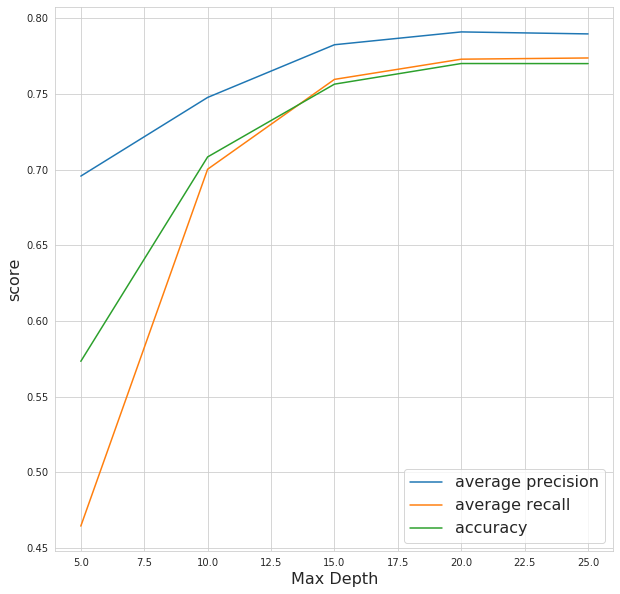

In [160]:
#Plotting the results
plt.figure(figsize=(10,10))
plt.plot(np.linspace(5,25,5),precision, label = 'average precision')
plt.plot(np.linspace(5,25,5),recall, label = 'average recall')
plt.plot(np.linspace(5,25,5),accuracy, label = 'accuracy')
plt.legend(fontsize=16)
plt.xlabel('Max Depth', fontsize=16)
plt.ylabel('score',fontsize=16)
plt.show()

In [173]:
#Testing various number of estimators at max_depth of 10
depth_scores = np.empty((5,72129))
nest = [5, 10, 50, 100,200]
for i in range(len(nest)):
    rfc = RandomForestClassifier(n_estimators = nest[i], max_depth=10)
    depth_scores[i] = list(cross_val_predict(rfc, X_train_scaled, y_train_ord.ravel(), cv=5))

In [174]:
#getting scores
precision = np.empty(5)
recall = np.empty(5)
accuracy = np.empty(5)
for i in range(5):
    precision[i] = precision_score(y_train_ord.ravel(), depth_scores[i], average = 'macro')
    recall[i] = recall_score(y_train_ord.ravel(),depth_scores[i], average = 'macro')
    accuracy[i] = accuracy_score(y_train_ord.ravel(),depth_scores[i])

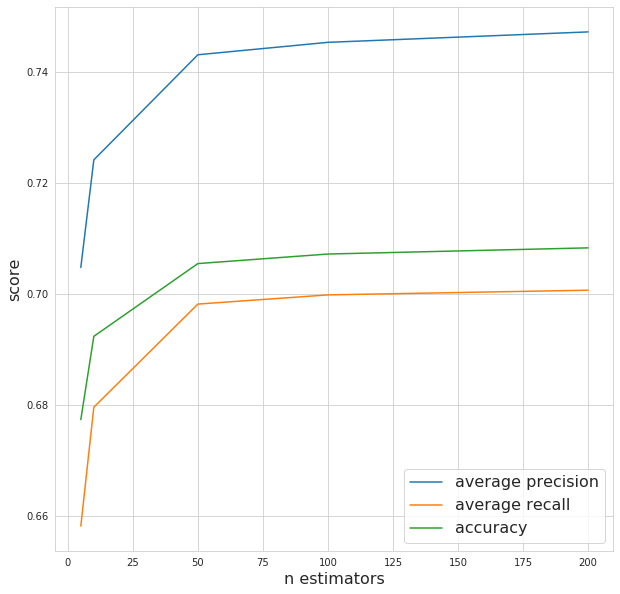

In [175]:
#plotting data
plt.figure(figsize=(10,10))
plt.plot(nest,precision, label = 'average precision')
plt.plot(nest,recall, label = 'average recall')
plt.plot(nest,accuracy, label = 'accuracy')
plt.legend(fontsize=16)
plt.xlabel('n estimators', fontsize=16)
plt.ylabel('score',fontsize=16)
plt.show()

## Getting overall results of precision accuracy and recall for the optimized hyperparameters

In [19]:
#defining classifier object
rfc = RandomForestClassifier(n_estimators=100, max_depth=10)

In [20]:
#fitting classifier
rfc.fit(X_train_scaled, y_train_ord.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [21]:
pred = rfc.predict(X_train_scaled)

In [22]:
precision_score(y_train_ord, pred, average='macro')

0.7950792021667865

In [23]:
#cross-validating the data
y_pred = cross_val_predict(rfc, X_train_scaled, y_train_ord.ravel(), cv=5)

In [24]:
#Using a bit of code from Kents classifier notebook
spe = ['loblolly pine','sweetgum','red maple','slash pine','yellow-poplar',
      'balsam fir','sugar maple','quaking aspen','northern white-cedar','paper birch']

In [26]:
pred_df = pd.DataFrame({'speciesID':y_train,'pred':y_pred,'correct': y_train == y_pred})
pred_df = pred_df.reset_index(drop = True)

precision = precision_score(y_train_ord.ravel(),y_pred, average = None)
recall = recall_score(y_train_ord.ravel(),y_pred, average = None)
matrix = confusion_matrix(y_train_ord.ravel(), y_pred)
accuracy = matrix.diagonal()/matrix.sum(axis=1)
speID = le.transform(spe)
orderedspecies = le.inverse_transform(np.sort(speID))
final = pd.DataFrame({'accuracy':np.zeros(len(recall)),
                      'recall':recall,
                      'precision':precision},
                     index = orderedspecies)
final.loc['Total'] = [accuracy_score(y_train_ord.ravel(),y_pred),
                      recall_score(y_train_ord.ravel(),y_pred, average = 'macro'),
                      precision_score(y_train_ord.ravel(),y_pred, average = 'macro')]
final

,accuracy,recall,precision
balsam fir,0.000000,0.816667,0.803690
loblolly pine,0.000000,0.664760,0.734358
northern white-cedar,0.000000,0.797452,0.770462
paper birch,0.000000,0.431166,0.708006
quaking aspen,0.000000,0.869618,0.749684
red maple,0.000000,0.807624,0.602177
slash pine,0.000000,0.621645,0.822435
sugar maple,0.000000,0.897627,0.945232
sweetgum,0.000000,0.343668,0.641410
yellow-poplar,0.000000,0.739376,0.686318


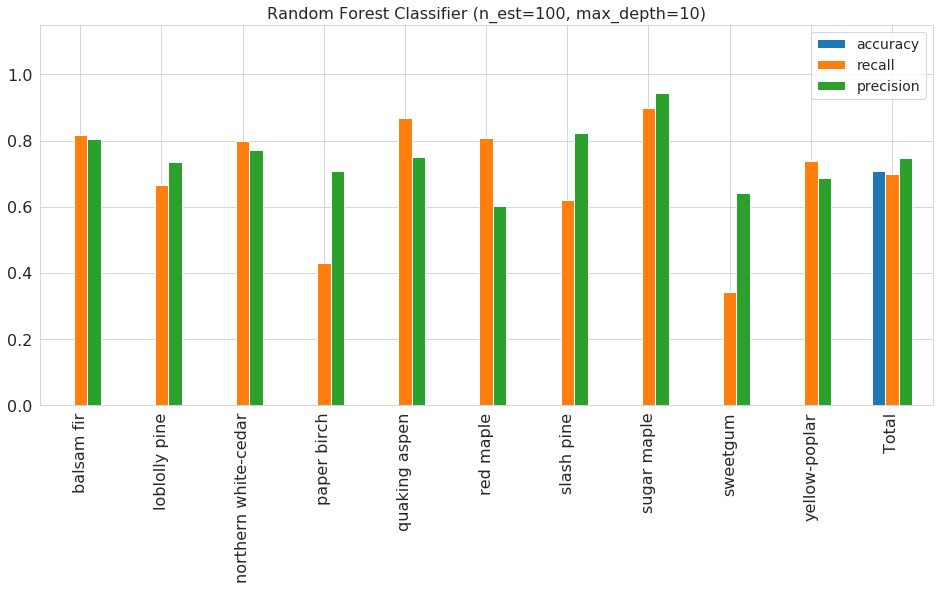

In [27]:
final.plot.bar(fontsize = 16,figsize = (16,7),legend = False)
plt.ylim((0,1.15))
plt.xlabel('',fontsize = 16)
plt.title('Random Forest Classifier (n_est=100, max_depth=10)',fontsize = 16)
plt.legend(loc = 1,fontsize = 14)
plt.show()

In [ ]:
rfc = Pipline([('scaler', StandardScaler()),
              ('PCA', PCA()),
              ('rfc', RandomForestClassifier(n_estimators=100, max_depth=10))])